## Import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import *
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import stateinterpreter

## Preprocessing

Load trajectory

In [3]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 100
#Load Collective Variables
colvar = stateinterpreter.load_dataframe(colvar_file, stride=stride).drop(['time'], axis=1)

Label states

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 1058 configurations.
	Basin 1 -> 789 configurations.
	Basin 2 -> 717 configurations.
	Basin 3 -> 2490 configurations.


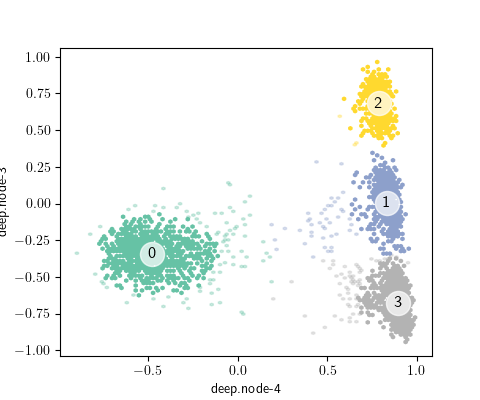

In [5]:
cv_list = ['deep.node-4', 'deep.node-3']
kBT = 2.8
bandwidth = 0.1
states_labels = stateinterpreter.metastable.identify_metastable_states(colvar, cv_list, kBT, bandwidth, gradient_descent_iterates=0, optimizer_kwargs={'num_init' : 50})
stateinterpreter.utils.plot.plot_states(colvar, states_labels, cv_list, fes_isolines=False);

## Group lasso

A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.

Optimizing Lasso Estimator: 100%|██████████| 25/25 [06:57<00:00, 16.69s/it]


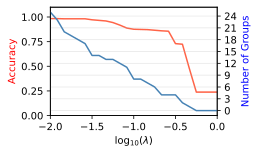

In [4]:
regularizers = np.geomspace(0.01, 1, 25)
#select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, states_names=states_names)
groups = [feats_info[name]['group'] for name in features_names]

classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

classifier.plot();

In [5]:
reg = 10**(-1)
classifier.print_selected(reg)

Accuracy: 87%
State Unfolded:
[84.833%]  ASP3_THR8
[13.433%]  TYR1_TYR10
[1.645% ]  TYR2_ASP3
[0.089% ]  TYR2_THR8
State Folded Mid:
[59.394%]  ASP3_GLY7
[21.101%]  ASP3_THR8
[19.505%]  THR6_THR8
State Folded High:
[74.284%]  THR8_TRP9
[15.475%]  THR6_THR8
[8.741% ]  THR6_GLY7
[1.5%   ]  TYR2_THR8
State Folded Low:
[99.512%]  THR6_THR8
[0.488% ]  ASP3_THR8


### Residue score (view & heatmap)

In [13]:
from stateinterpreter.io import load_trajectory

traj = load_trajectory(traj_dict, stride=stride)
# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

In [14]:
residue_score

{'Unfolded': array([0.00000000e+00, 4.20477014e-02, 4.30719916e-01, 0.00000000e+00,
        0.00000000e+00, 3.29123367e-02, 0.00000000e+00, 4.94295543e-01,
        2.45036698e-05, 0.00000000e+00]),
 'Folded Mid': array([0.00000000e+00, 8.35674034e-03, 1.44680965e-01, 0.00000000e+00,
        0.00000000e+00, 3.48540565e-01, 0.00000000e+00, 4.98411560e-01,
        1.01694282e-05, 0.00000000e+00]),
 'Folded High': array([0.00000000e+00, 1.39422545e-02, 9.78903112e-02, 0.00000000e+00,
        0.00000000e+00, 3.90340341e-01, 0.00000000e+00, 4.97778337e-01,
        4.87565692e-05, 0.00000000e+00]),
 'Folded Low': array([0.00000000e+00, 1.66320296e-03, 3.78462729e-02, 0.00000000e+00,
        0.00000000e+00, 4.60929196e-01, 0.00000000e+00, 4.99554767e-01,
        6.56108504e-06, 0.00000000e+00])}

Visualize structure

In [15]:
from stateinterpreter.visualize import visualize_residue_score

visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='licorice')

NGLWidget(max_frame=3)

Heatmap

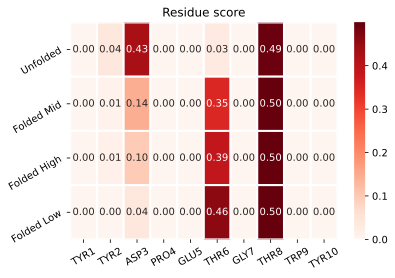

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get residue names
table, _ = traj.topology.to_dataframe()
residue_names = table["resName"] + table["resSeq"].astype("str")
residue_names = residue_names.unique()

# transform dictionary of residue scores into matrix and then into df to plot with seaborn (switch back to matplotlib?)
score_matrix = np.row_stack([score for score in residue_score.values()])
score_df = pd.DataFrame(score_matrix, columns = residue_names, index=states_names)

# Plot
sns.heatmap(score_df, annot=True, fmt=".2f", cmap='Reds', linewidths=2)

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Residue score')
plt.show()

## Standard Lasso

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:02<00:00,  8.61it/s]


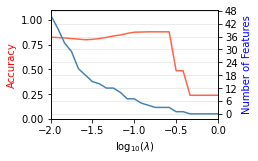

In [8]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, regex_filter = select_feat, states_names=states_names)

classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000)

classifier.plot();

In [9]:
reg = 10**(-1)
classifier.print_selected(reg)

Accuracy: 87%
State Unfolded:
[99.991%]  SIDECHAIN cos_chi1 ASP3
[0.009% ]  SIDECHAIN cos_chi1 TYR2
State Folded Mid:
[100.0% ]  SIDECHAIN cos_chi1 ASP3
State Folded High:
[75.478%]  SIDECHAIN cos_chi1 THR8
[24.204%]  SIDECHAIN sin_chi1 THR6
[0.295% ]  BACKBONE cos_phi GLY7
[0.023% ]  BACKBONE sin_psi THR6
State Folded Low:
[71.062%]  SIDECHAIN sin_chi1 THR6
[16.797%]  SIDECHAIN cos_chi1 THR8
[11.272%]  SIDECHAIN cos_chi1 ASP3
[0.869% ]  SIDECHAIN sin_chi1 THR8


### Plot relevant features in CVs space

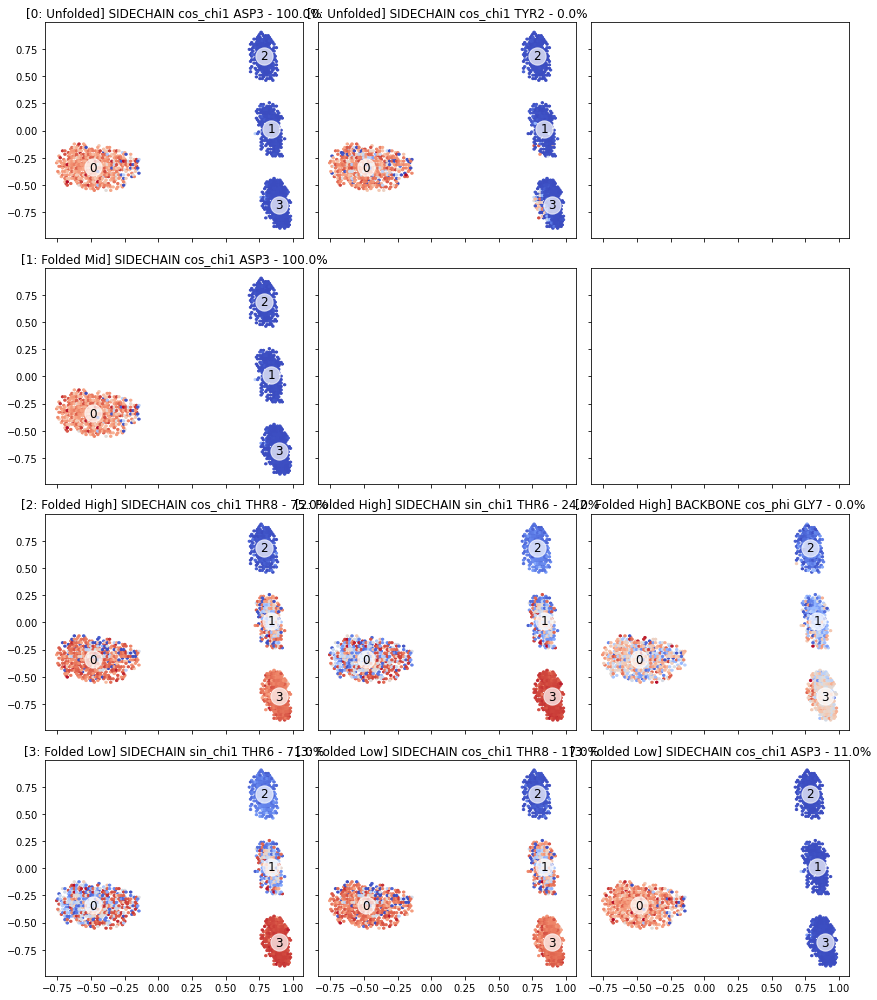

In [10]:
from stateinterpreter.plot import plot_combination_states_features

relevant_feat = classifier.feature_summary(reg)
plot_combination_states_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)
plt.tight_layout()

### Visualize 3d structure

In [ ]:
from stateinterpreter.visualize import visualize_features
from stateinterpreter.io import load_trajectory

traj = load_trajectory(traj_dict,stride=stride)
visualize_features(traj, states_labels, classes_names, relevant_feat, feats_info, state = 3, representation = 'licorice')

### Histograms

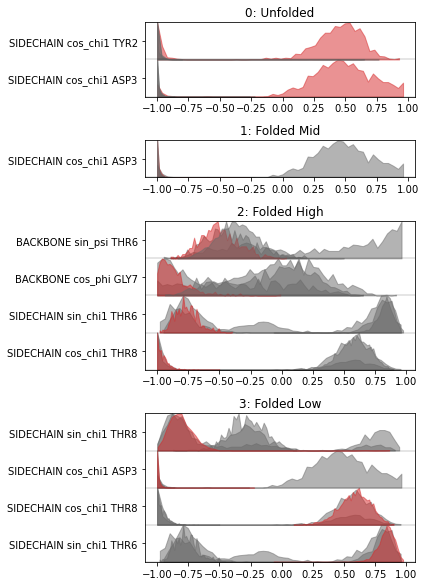

In [11]:
from stateinterpreter.plot import plot_histogram_features

plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)